# Optimización de la Función f(x,y) = (x²-1)² + (y²-2)²

Este notebook implementa métodos de optimización para minimizar la función objetivo.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import json
import time
from pathlib import Path

## Definición de la Función Objetivo y su Gradiente

In [2]:
def f(x):
    """Función objetivo: f(x,y) = (x²-1)² + (y²-2)²"""
    return (x[0]**2 - 1)**2 + (x[1]**2 - 2)**2

def grad_f(x):
    """Gradiente de f"""
    df_dx = 4 * x[0] * (x[0]**2 - 1)
    df_dy = 4 * x[1] * (x[1]**2 - 2)
    return np.array([df_dx, df_dy])

## Implementación del Descenso del Gradiente

In [3]:
def gradient_descent(x0, learning_rate, tol, max_iter):
    """Método del Descenso del Gradiente"""
    x = np.array(x0, dtype=float)
    trajectory = [x.copy()]
    iterations = 0
    
    for i in range(max_iter):
        grad = grad_f(x)
        if np.linalg.norm(grad) < tol:
            iterations = i + 1
            break
        x = x - learning_rate * grad
        trajectory.append(x.copy())
        iterations = i + 1
    
    return {
        'x_opt': x.tolist(),
        'f_opt': float(f(x)),
        'iterations': iterations,
        'trajectory': [p.tolist() for p in trajectory]
    }

## Implementación del Método Cuasi-Newton BFGS

In [4]:
def bfgs_method(x0, tol, max_iter):
    """Método BFGS usando scipy.optimize.minimize"""
    trajectory = []
    
    def callback(xk):
        trajectory.append(xk.copy())
    
    result = minimize(
        f, 
        x0, 
        method='BFGS',
        jac=grad_f,
        tol=tol,
        options={'maxiter': max_iter},
        callback=callback
    )
    
    return {
        'x_opt': result.x.tolist(),
        'f_opt': float(result.fun),
        'iterations': result.nit,
        'trajectory': [p.tolist() for p in trajectory]
    }

## Framework de Experimentación

In [5]:
def MakeExperiments():
    """Ejecuta experimentos desde archivos JSON de configuración"""
    exp_dir = Path('Experiments')
    results_dir = Path('Results')
    results_dir.mkdir(exist_ok=True)
    
    exp_files = sorted(exp_dir.glob('exp*.json'))
    
    for exp_file in exp_files:
        with open(exp_file, 'r') as f:
            experiments = json.load(f)
        
        print(f"\nEjecutando {exp_file.name}...")
        print(f"Total de experimentos en este archivo: {len(experiments)}")
        
        all_results = []
        
        for idx, config in enumerate(experiments, 1):
            print(f"\n  Experimento {idx}/{len(experiments)}")
            print(f"  Configuración: {config}")
            
            # Gradient Descent
            start_time = time.time()
            gd_result = gradient_descent(
                config['x0'],
                config['learning_rate'],
                config['tol'],
                config['max_iter']
            )
            gd_time = time.time() - start_time
            
            # BFGS
            start_time = time.time()
            bfgs_result = bfgs_method(
                config['x0'],
                config['tol'],
                config['max_iter']
            )
            bfgs_time = time.time() - start_time
            
            # Guardar resultado de este experimento
            result = {
                'config': config,
                'gradient_descent': {
                    **gd_result,
                    'execution_time': gd_time
                },
                'bfgs': {
                    **bfgs_result,
                    'execution_time': bfgs_time
                },
                'theoretical_minimum': {'x': [1.0, np.sqrt(2)], 'f': 0.0}
            }
            
            all_results.append(result)
        
        # Guardar todos los resultados de este archivo
        result_file = results_dir / f"results_{exp_file.name}"
        with open(result_file, 'w') as f:
            json.dump(all_results, f, indent=2)
        
        print(f"\nResultados guardados en {result_file}")

## Ejecución de Experimentos

In [7]:
MakeExperiments()


Ejecutando exp1.json...
Total de experimentos en este archivo: 1

  Experimento 1/1
  Configuración: {'learning_rate': 0.1, 'tol': 1e-06, 'max_iter': 1000, 'x0': [0.5, 0.5]}

Resultados guardados en Results/results_exp1.json

Ejecutando exp2.json...
Total de experimentos en este archivo: 1

  Experimento 1/1
  Configuración: {'learning_rate': 0.05, 'tol': 1e-06, 'max_iter': 2000, 'x0': [-1.5, -1.0]}

Resultados guardados en Results/results_exp2.json


## Visualización de Resultados

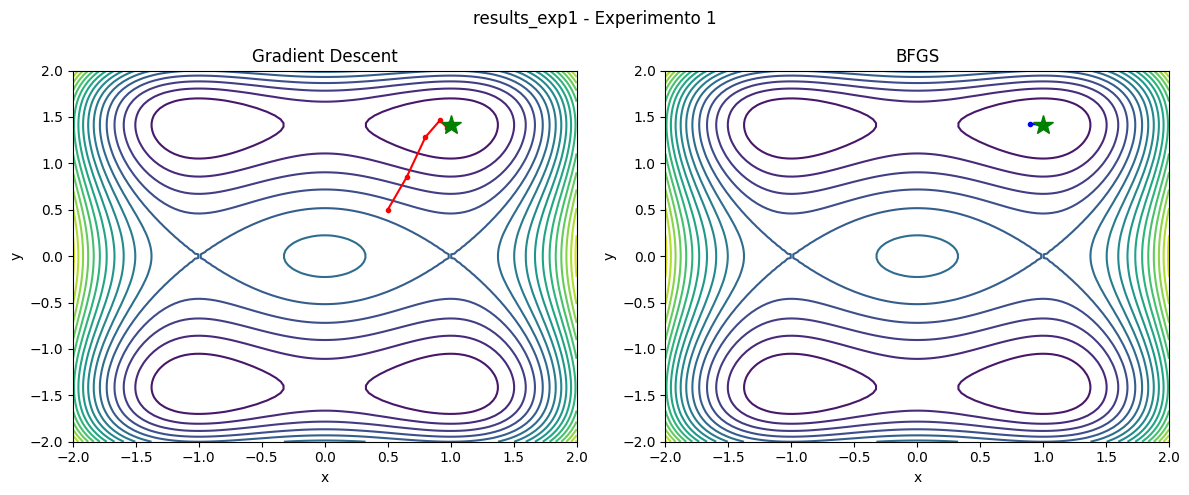

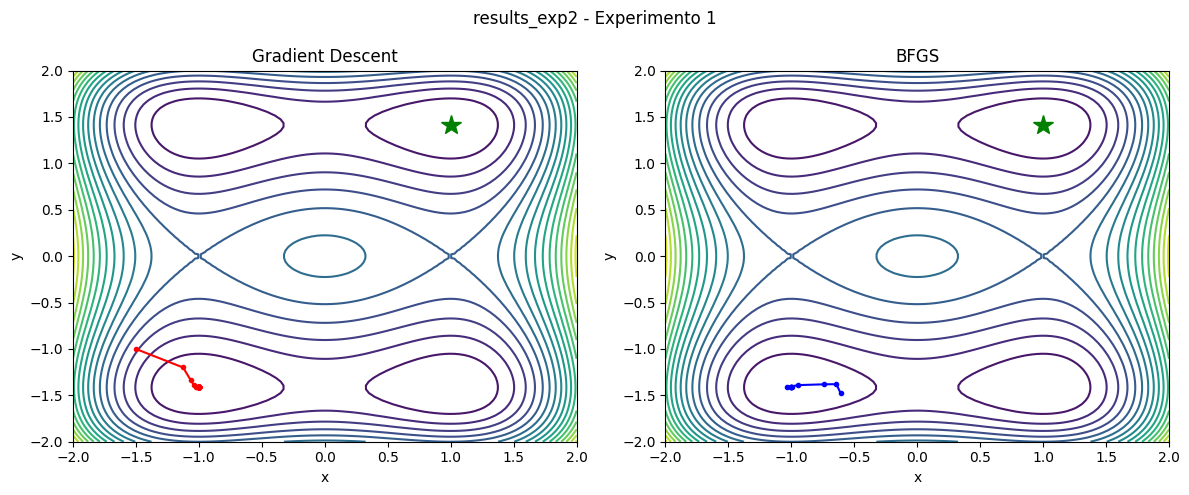

In [8]:
def plot_results():
    """Visualiza los resultados de los experimentos"""
    results_dir = Path('Results')
    result_files = sorted(results_dir.glob('results_*.json'))
    
    for result_file in result_files:
        with open(result_file, 'r') as f:
            all_results = json.load(f)
        
        # Iterar sobre cada experimento en el archivo de resultados
        for idx, results in enumerate(all_results, 1):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            
            # Contornos de la función
            x = np.linspace(-2, 2, 100)
            y = np.linspace(-2, 2, 100)
            X, Y = np.meshgrid(x, y)
            Z = (X**2 - 1)**2 + (Y**2 - 2)**2
            
            # Gradient Descent
            ax1.contour(X, Y, Z, levels=20)
            traj = np.array(results['gradient_descent']['trajectory'])
            ax1.plot(traj[:, 0], traj[:, 1], 'ro-', markersize=3)
            ax1.plot(1, np.sqrt(2), 'g*', markersize=15)
            ax1.set_title('Gradient Descent')
            ax1.set_xlabel('x')
            ax1.set_ylabel('y')
            
            # BFGS
            ax2.contour(X, Y, Z, levels=20)
            traj = np.array(results['bfgs']['trajectory'])
            ax2.plot(traj[:, 0], traj[:, 1], 'bo-', markersize=3)
            ax2.plot(1, np.sqrt(2), 'g*', markersize=15)
            ax2.set_title('BFGS')
            ax2.set_xlabel('x')
            ax2.set_ylabel('y')
            
            plt.suptitle(f"{result_file.stem} - Experimento {idx}")
            plt.tight_layout()
            plt.show()

plot_results()

## Análisis Comparativo

In [9]:
def comparative_analysis():
    """Análisis comparativo de los métodos"""
    results_dir = Path('Results')
    result_files = sorted(results_dir.glob('results_*.json'))
    
    for result_file in result_files:
        with open(result_file, 'r') as f:
            all_results = json.load(f)
        
        print(f"\n{'='*60}")
        print(f"Archivo: {result_file.stem}")
        print(f"Total de experimentos: {len(all_results)}")
        print(f"{'='*60}")
        
        # Iterar sobre cada experimento en el archivo de resultados
        for idx, results in enumerate(all_results, 1):
            print(f"\n--- Experimento {idx}/{len(all_results)} ---")
            print(f"Punto inicial: {results['config']['x0']}")
            print(f"Learning rate: {results['config']['learning_rate']}")
            print(f"Tolerancia: {results['config']['tol']}")
            print()
            
            gd = results['gradient_descent']
            bfgs = results['bfgs']
            
            print("GRADIENT DESCENT:")
            print(f"  Iteraciones: {gd['iterations']}")
            print(f"  Tiempo: {gd['execution_time']:.6f} s")
            print(f"  Solución: {gd['x_opt']}")
            print(f"  f(x): {gd['f_opt']:.10f}")
            
            print("\nBFGS:")
            print(f"  Iteraciones: {bfgs['iterations']}")
            print(f"  Tiempo: {bfgs['execution_time']:.6f} s")
            print(f"  Solución: {bfgs['x_opt']}")
            print(f"  f(x): {bfgs['f_opt']:.10f}")
            
            print("\nMÍNIMO TEÓRICO:")
            print(f"  x* = {results['theoretical_minimum']['x']}")
            print(f"  f(x*) = {results['theoretical_minimum']['f']}")

comparative_analysis()


Archivo: results_exp1
Total de experimentos: 1

--- Experimento 1/1 ---
Punto inicial: [0.5, 0.5]
Learning rate: 0.1
Tolerancia: 1e-06

GRADIENT DESCENT:
  Iteraciones: 31
  Tiempo: 0.000786 s
  Solución: [1.0, 1.4142135077324858]
  f(x): 0.0000000000

BFGS:
  Iteraciones: 8
  Tiempo: 0.004239 s
  Solución: [0.9999999997733616, 1.4142135626137728]
  f(x): 0.0000000000

MÍNIMO TEÓRICO:
  x* = [1.0, 1.4142135623730951]
  f(x*) = 0.0

Archivo: results_exp2
Total de experimentos: 1

--- Experimento 1/1 ---
Punto inicial: [-1.5, -1.0]
Learning rate: 0.05
Tolerancia: 1e-06

GRADIENT DESCENT:
  Iteraciones: 29
  Tiempo: 0.000486 s
  Solución: [-1.0000000949221568, -1.4142135623730951]
  f(x): 0.0000000000

BFGS:
  Iteraciones: 10
  Tiempo: 0.002468 s
  Solución: [-0.9999999980646455, -1.414213562882495]
  f(x): 0.0000000000

MÍNIMO TEÓRICO:
  x* = [1.0, 1.4142135623730951]
  f(x*) = 0.0
